<a href="https://colab.research.google.com/github/kevinszuchet/ia-notebooks-dot-csv/blob/main/04_red_neuronal_desde_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

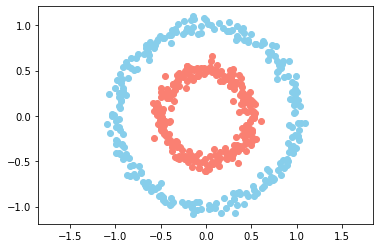

In [2]:
# Crear el dataset

n = 500 # Cantidad de registros
p = 2 # Cantidad de features

# Y: Las 2 clases a las que pertenecen los círculos (uno o el otro)
X, Y = make_circles(n_samples=n, factor=0.5, noise=0.05)
Y = Y[:, np.newaxis]

plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c="skyblue")
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c="salmon")
plt.axis("equal") # Ejes con la misma proporción
plt.show()

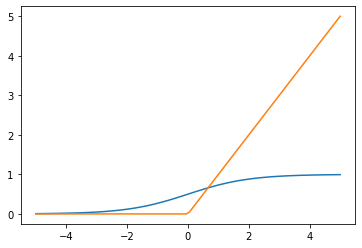

In [3]:
# Dentro de una capa realizamos las mismas operaciones para todas las neuronas (misma función de activación, backpropagation, etc)
# Cada neurona es una unidad de procesamiento -> Cada capa es un módulo

# Capas
class neural_layer():

  def __init__(self, n_connections, n_neurons, activation_function):
    self.activation_function = activation_function
    
    # La normalizamos y estandarizamos entre -1 y 1
    self.b = np.random.rand(1, n_neurons) * 2 - 1
    self.W = np.random.rand(n_connections, n_neurons) * 2 - 1

# Funciones de activación
sigmoid = (lambda x: 1 / (1 + np.e ** (-x)), lambda x: x * (1 - x))

relu = lambda x: np.maximum(0, x)

# Variable que va de -5 a 5 de forma líneal con 100 valores generados 
_x = np.linspace(-5, 5, 100)
plt.plot(_x, sigmoid[0](_x))
plt.plot(_x, relu(_x))

In [4]:
l0 = neural_layer(p, 4, sigmoid)
l1 = neural_layer(4, 8, sigmoid)
# ...

def create_neural_network(topology, activation_function):
  neural_network = []

  for l, layer in enumerate(topology[:-1]):
    neural_network.append(neural_layer(topology[l], topology[l + 1], activation_function))

  return neural_network

In [9]:
topology = [p, 4, 8, 1] # [p, 4, 8, 16, 8, 4, 1]
neural_network = create_neural_network(topology, sigmoid)

# La red procesa hacia adelante
# Se comparan los resultados con Y (y obtenemos el error con la función de costos)
# Propagamos el error hacia atrás para calcular las derivadas parciales y, con ellas, ejecutar el gradient descend
# Con esto optimizamos la función de costos para entrenar la red

l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr) ** 2), lambda Yp, Yr: (Yp - Yr))

def train(neural_network, X, Y, l2_cost, learning_rate=0.5, train=True):
  # [(z0, a0), (z1, a1), ..., (zn, an)]
  output = [(None, X)]
  
  # Forward pass
  for l, layer in enumerate(neural_network):
    z = output[-1][1] @ neural_network[l].W + neural_network[l].b
    a = neural_network[l].activation_function[0](z)

    output.append((z, a))

  if train:

    # Backward pass
    deltas = []

    for l  in reversed(range(0, len(neural_network))):
      z = output[l + 1][0]
      a = output[l + 1][1]
      
      if l == (len(neural_network) - 1):
        # Calcular delta de la última capa
        deltas.insert(0, l2_cost[1](a, Y) * neural_network[l].activation_function[1](a))
      else:
        # Calcular delta respecto de la capa previa
        deltas.insert(0, deltas[0] @ _W * neural_network[l].activation_function[1](a))
      _W = neural_network[l].W.T

      # Gradient Descent
      neural_network[l].b -= np.mean(deltas[0], axis=0, keepdims=True) * learning_rate
      neural_network[l].W -= output[l][1].T @ deltas[0] * learning_rate

    return output[-1][1]


train(neural_network, X, Y, l2_cost, 0.5)
print("")

In [10]:
import time
from IPython.display import clear_output

neural_network = create_neural_network(topology, sigmoid)

loss = [] # Diferentes costos para graficar la evolución en el tiempo

for i in range(2500):

  pY = train(neural_network, X, Y, l2_cost, learning_rate=0.05)

  # Cada 25 iteraciones
  if i % 25 == 0:
    # Calculamos el costo
    loss.append(l2_cost[0](pY, Y))

    # Generamos una malla de 50x50
    res = 50

    _x0 = np.linspace(-1.5, 1.5, res)
    _x1 = np.linspace(-1.5, 1.5, res)

    _Y = np.zeros((res, res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        # Predecimos el resultado de la red
        _Y[i0, i1] = train(neural_network, np.array([[x0, x1]]), Y, l2_cost)[0][0]
    
    plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
    plt.axis("equal")

    plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c="skyblue")
    plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c="salmon")

    clear_output(wait=True)
    plt.show()
    plt.plot(range(len(loss)), loss)
    plt.show()
    time.sleep(0.5)

ValueError: ignored